In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.optimize as optm

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import collections
import functools
import random

import optics_funs as of
import numerical_funs as nf
import math_funs as mf
import matplotlib_funs as mpf
import LCT_funs as lctf
import general_funs as gef

import new_types as nt
import mutants

import finesse
import finesse.ligo as aligo

import func_funs as ff
import graph_funs as grf
import finesse3_funs as f3f
import wolfram_funs as wlf

import networkx as nx
# import pygraphviz as pgv
import pydot

from IPython.display import Image, SVG

In [6]:
print(aligo.aligo_katscript)


# modulators for core interferometer sensing - Advanced LIGO, CQG, 2015
# http://iopscience.iop.org/article/10.1088/0264-9381/32/7/074001/meta#cqg507871s4-8
# 9MHz (CARM, PRC, SRC loops)
variable f1 9099471
variable f2 5*&f1
variable nsilica 1.45
variable Mloss 30u
###############################################################################
###   length definitions
###############################################################################
variable Larm 3994
variable LPR23 16.164  # distance between PR2 and PR3
variable LSR23 15.443  # distance between SR2 and SR3
variable LPR3BS 19.538 # distance between PR3 and BS
variable LSR3BS 19.366 # distance between SR3 and BS
variable lmich 5.342   # average length of MICH
variable lschnupp 0.08
variable lPRC (3+0.5)*c0/(2*&f1) # T1000298 Eq2.1, N=3
variable lSRC (17)*c0/(2*&f2) # T1000298 Eq2.2, M=3
###############################################################################
###   laser
#############################################

In [3]:
kat = aligo.make_aligo()

In [4]:
def angle_between(x,y):
    d = x-y
    return np.arctan2(np.sin(d), np.cos(d))

def gouy_between(x,y):
    return angle_between(2*x, 2*y)/2

def complex_angle_between(z1, z2):
    x1, y1 = z1.real, z1.imag
    x2, y2 = z2.real, z2.imag
    return np.arctan2(x1*y2 - y1*x2, x1*x2 + y1*y2)

def gouy_matrix(nodes, tablefmt="fancy_grid"):
    from tabulate import tabulate
    
    out = []
    for ni in nodes:
        t_ = [ni.full_name]
        for nj in nodes:
            gouy_angle = gouy_between(ni.qx.gouy(), nj.qx.gouy())/np.pi*180
            t_.append(gouy_angle)
        out.append(t_)
        
    headers = [n.full_name for n in nodes]
    out_str = tabulate(out, headers, tablefmt=tablefmt)
    return out_str

def angle_matrix(zs, tablefmt="fancy_grid"):
    from tabulate import tabulate
    
    out = []
    for zi in zs:
        t_ = []
        for zj in zs:
            angle_sep = complex_angle_between(zi, zj)/np.pi*180
            t_.append(angle_sep)
        out.append(t_)
        
    out_str = tabulate(out, tablefmt=tablefmt)
    return out_str

def gouy_matrix(nodes, model=None, ref_node=None, dl=1e-8, abs_angle=True, tablefmt="fancy_grid"):
    from tabulate import tabulate
    
    if ref_node is None:
        ref_node = nodes[0]
    if model is None:
        model = nodes[0]._model
        
    lp = of.abcd.lens_p(dl)   
    
    dqs = []
    for n in nodes:
        q = n.qx.q
        q2 = of.q.propag(q, lp)
        q_ref = model.propagate_beam(n, ref_node, q_in=q).q(ref_node).q
        q2_ref = model.propagate_beam(n, ref_node, q_in=q2).q(ref_node).q
        
        dq = q_ref - q2_ref
        dqs.append(dq)
        
    out = []
    for ni,zi in zip(nodes, dqs):
        t_ = [ni.full_name]
        for zj in dqs:
            angle_sep = complex_angle_between(zi, zj)/np.pi*180
            if abs_angle:
                angle_sep = np.abs(angle_sep)
            t_.append(angle_sep)
        out.append(t_)
        
    headers = [n.full_name for n in nodes]
    out_str = tabulate(out, headers, tablefmt=tablefmt)
    return out_str

In [5]:
# nodes = [kat.SRM.p1.i, kat.SRM.p1.o, kat.SR2.p1.i, kat.SR2.p2.o, kat.SR3.p1.i, kat.SR3.p2.o, kat.ITMY.p1.i, kat.ITMY.p1.o]
nodes = [kat.SRM.p1.o, kat.SR2.p2.o, kat.SR3.p2.o, kat.ITMY.p1.o]
qs = [n.qx.q for n in nodes]

dl = 1e-8
lp = of.abcd.lens_p(dl)

q2s = of.q.propag(qs, lp)
dqs = (q2s - qs)/dl

In [6]:
print(gouy_matrix(nodes, ref_node=kat.OMC_CM2.p1.i))

╒═══════════╤════════════╤════════════╤════════════╤═════════════╕
│           │   SRM.p1.o │   SR2.p2.o │   SR3.p2.o │   ITMY.p1.o │
╞═══════════╪════════════╪════════════╪════════════╪═════════════╡
│ SRM.p1.o  │     0      │   56.1482  │  54.7929   │   54.4769   │
├───────────┼────────────┼────────────┼────────────┼─────────────┤
│ SR2.p2.o  │    56.1482 │    0       │   1.35528  │    1.67128  │
├───────────┼────────────┼────────────┼────────────┼─────────────┤
│ SR3.p2.o  │    54.7929 │    1.35528 │   0        │    0.315994 │
├───────────┼────────────┼────────────┼────────────┼─────────────┤
│ ITMY.p1.o │    54.4769 │    1.67128 │   0.315994 │    0        │
╘═══════════╧════════════╧════════════╧════════════╧═════════════╛


In [7]:
q2s

array([    4.76401937 +2.14073982e+00j,   -20.52184036 +2.14073873e+00j,
         -18.21678734 +3.86956780e-02j,  1885.12027775 +3.03668680e+02j])

In [8]:
dqs

array([  1.81131132e+01 +2.03970506e+01j,
         4.16563253e+02 -8.78638241e+01j,
         3.31849904e+02 -1.40982226e+00j,   3.46140202e+06 +1.14487188e+06j])

In [9]:
print(angle_matrix(dqs))

╒═════════╤══════════╤══════════╤══════════╕
│  0      │ -60.3046 │ -48.6375 │ -30.0923 │
├─────────┼──────────┼──────────┼──────────┤
│ 60.3046 │   0      │  11.6671 │  30.2124 │
├─────────┼──────────┼──────────┼──────────┤
│ 48.6375 │ -11.6671 │   0      │  18.5452 │
├─────────┼──────────┼──────────┼──────────┤
│ 30.0923 │ -30.2124 │ -18.5452 │   0      │
╘═════════╧══════════╧══════════╧══════════╛


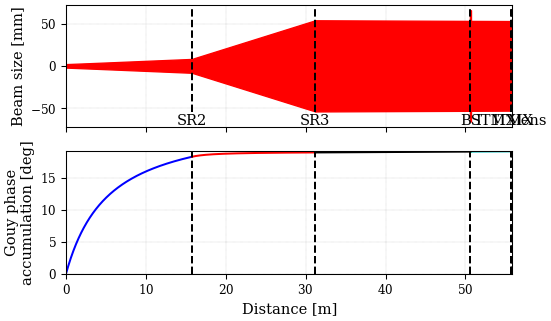

(<Figure size 576x355.968 with 2 Axes>,
 array([<AxesSubplot:ylabel='Beam size [mm]'>,
        <AxesSubplot:xlabel='Distance [m]', ylabel='Gouy phase\naccumulation [deg]'>], dtype=object))

In [108]:
# ps = kat.propagate_beam(from_node=kat.SRM.p1.i, to_node=kat.ITMY.p1.i)
ps = kat.propagate_beam(from_node=kat.SRM.p1.o, to_node=kat.ITMX.p1.i)
ps.plot()


In [120]:
# ps = kat.propagate_beam(from_node=kat.SRM.p1.i, to_node=kat.ITMY.p1.i)
ps = kat.propagate_beam(from_node=kat.SRM.p1.o, to_node=kat.SRM.p1.i, via_node=kat.ITMX.p1.i)

tab = ps.make_table()
tab = print(ps)

╒═══════════════╤══════════╤═══════════╤═════════════╤══════════╤═════════════╤═══════════════════╤══════════════════════╕
│ Name          │    z [m] │   w0 [mm] │      zr [m] │   w [mm] │     RoC [m] │   Acc. Gouy [deg] │ q                    │
╞═══════════════╪══════════╪═══════════╪═════════════╪══════════╪═════════════╪═══════════════════╪══════════════════════╡
│ SRM.p1.o      │   0      │  0.851487 │   2.14074   │  2.07742 │     5.72597 │            0      │ 4.764 + 2.141j       │
├───────────────┼──────────┼───────────┼─────────────┼──────────┼─────────────┼───────────────────┼──────────────────────┤
│ SR2.p2.i      │  15.7578 │  0.851487 │   2.14074   │  8.20693 │    20.7452  │           18.2418 │ 20.522 + 2.141j      │
├───────────────┼──────────┼───────────┼─────────────┼──────────┼─────────────┼───────────────────┼──────────────────────┤
│ SR2.p1.o      │  15.7578 │  0.114479 │   0.0386957 │  8.20693 │     2.77433 │           18.2418 │ 2.774 + 0.039j       │
├───────────────

In [121]:
edges = grf.path_to_edge_list(ps.nodes)

path = [n.full_name for n in ps.nodes]
edge_list = grf.path_to_edge_list(path)
zs = [0]
dzs = []

gouys = [0]
dgs = []
for e in edge_list:
    comp = kat.optical_network.edges[e]['owner']()
    if isinstance(comp, finesse.components.Space):
        dz = f3f.sym_eval(comp.L.value)
    else:
        dz = 0
    dg = kat.acc_gouy(*e)
        
    dzs.append(dz)
    dgs.append(dg)
    
    next_gouy = gouys[-1] + dg
    next_z = zs[-1] + dz
    
    zs.append(next_z)
    gouys.append(next_gouy)

In [235]:
edges = grf.path_to_edge_list(ps.nodes)

path = [n.full_name for n in ps.nodes]
edge_list = grf.path_to_edge_list(path)

zs = [0]
dzs = []
gouys = [0]
dgs = []

ws = []

optics = []
for e in edge_list:
    comp = kat.optical_network.edges[e]['owner']()
    if isinstance(comp, finesse.components.Space):
        dz = f3f.sym_eval(comp.L.value)
        dzs = np.linspace(0, dz, 101)
        nr = f3f.sym_eval(comp.nr.value)
    else:
        dz = 0
        dzs = np.array([0])
        nr = 1
        
    q0 = gef.getattr(kat, e[0]).qy.q
    q1s = q0 + dzs
    
    g1s = np.angle(of.q.get_gouy_nm(q1s), deg=True)
    g1s -= g1s[0]
    
    zs = np.hstack([zs, dzs[1:] + zs[-1]])
    gouys = np.hstack([gouys, g1s[1:] + gouys[-1]])
    
    ws.append(of.q.get_w(q1s)[1:]/np.sqrt(nr))
    
    optics.append((comp.name, zs[-1]))
    
q0 = gef.getattr(kat,path[0]).qy.q
ws = np.hstack([of.q.get_w(q0)] + ws)
    
important_optics = [x for x in optics if x[0] in ['SR2','SR3','SRM','BS','ITMX']]
important_optics = [('SRM', 0)] + important_optics + [('SRM', zs[-1])]

/home/alexei/git/alexei_thesis/notebooks/commissioning/SR3_heater_contour_model/../SRC_accum_gouy.png
/home/alexei/git/alexei_thesis/notebooks/commissioning/SR3_heater_contour_model/../SRC_accum_gouy.pdf


0

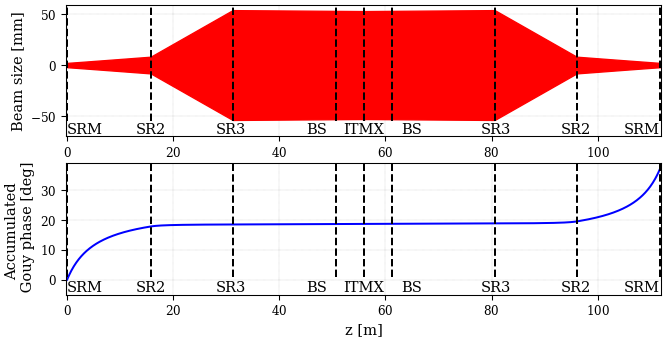

In [336]:
fig, ax = plt.subplots(2,1, figsize=[8,4])

plt.sca(ax[0])

plt.fill_between(zs,ws*1e3,-ws*1e3, color='r')
for o,v in important_optics:
    plt.axvline(v, 0.12, 1, ls='--', c='k')
    
v = -67
plt.text(0, v, 'SRM')
plt.text(13, v, 'SR2')
plt.text(28, v, 'SR3')
plt.text(45, v, 'BS')
plt.text(52, v, 'ITMX')
plt.text(63, v, 'BS')
plt.text(78, v, 'SR3')
plt.text(93, v, 'SR2')
plt.text(105, v, 'SRM')

plt.xlim([-0.2, zs[-1]+0.2])
plt.ylim([v-3, None])
# plt.xlabel('z [m]')
plt.ylabel('Beam size [mm]')

plt.sca(ax[1])

plt.plot(zs,gouys)
for o,v in important_optics:
    plt.axvline(v, 0.13, 1, ls='--', c='k')
    
v = -4
plt.text(0, v, 'SRM')
plt.text(13, v, 'SR2')
plt.text(28, v, 'SR3')
plt.text(45, v, 'BS')
plt.text(52, v, 'ITMX')
plt.text(63, v, 'BS')
plt.text(78, v, 'SR3')
plt.text(93, v, 'SR2')
plt.text(105, v, 'SRM')

plt.xlim([-0.2, zs[-1]+0.2])
plt.ylim([v-1, None])
plt.xlabel('z [m]')
plt.ylabel('Accumulated \n Gouy phase [deg]')

mpf.thesis_savefig(fig,'../SRC_accum_gouy', resize=False)